In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
np.random.seed(42)
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Problem settings

In [ ]:
def analytical_solution(t, k, mu, m):
    omega = torch.sqrt(4*m*k-mu**2)/(2*m)
    decay = torch.exp(-mu/(2*m)*t)
    sin = torch.cos(omega*t) + (mu/(2*m))/omega * torch.sin(omega*t)
    u_analytical = decay * sin
    return u_analytical

Note something about the problem settings here

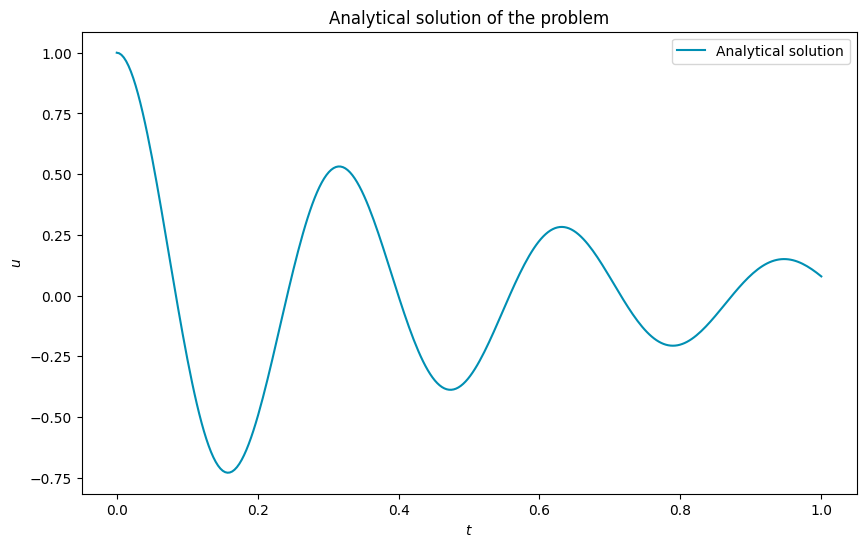

In [ ]:
k = torch.tensor(400)
mu = torch.tensor(4)
m = torch.tensor(1)
t_max = torch.tensor(1)
light_cyan = "#008fb3"
light_orange = "#ff8000"
# ground truth for evaluation
t_test = torch.linspace(0, 1, 300).double().view(-1,1)
u_test = analytical_solution(t_test, k, mu, m)
t_test_cuda = t_test.to(device)
u_test_cuda = u_test.to(device)
# visualize grouth truth
plt.figure(figsize=(10,6))
plt.plot(t_test, u_test, label="Analytical solution", color=light_cyan)
plt.xlabel("$t$")
plt.ylabel("$u$")
plt.title("Analytical solution of the problem")
plt.legend()
plt.show()

# Model training

## Example sampling in training loop

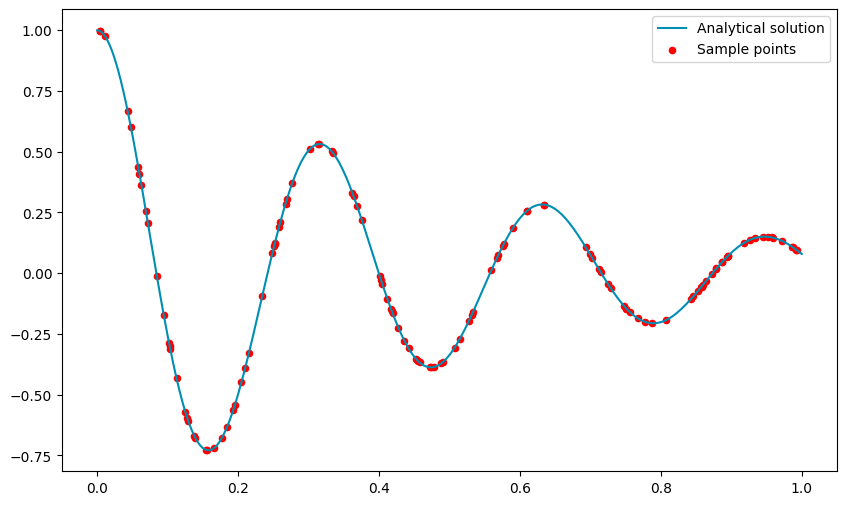

In [ ]:
n_samples = 125

g = torch.Generator(device=device)
t_pde = torch.rand(n_samples, device=device, generator=g).view(-1,1).double()
t_pde = t_pde * t_max # scale with [0,t_max]
t_pde.requires_grad = True
t_pde_cpu = t_pde.cpu()
t_pde_numpy = t_pde_cpu.detach().numpy()
u_pde = analytical_solution(t_pde_numpy, k, mu, m)
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)
t_boundary = t_boundary.double()

# visualize random samples
plt.figure(figsize=(10,6))
plt.plot(t_test, u_test, color=light_cyan,label="Analytical solution")
plt.scatter(t_pde_numpy, u_pde, color="red", s=20, label="Sample points")
plt.legend()
plt.show()

## Model setup

In [ ]:
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        #self.input_layer = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation()])
        #self.hidden_layers = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN),activation()]) for _ in range(N_LAYERS-1)])
        #self.output_layer = nn.Linear(N_HIDDEN, N_OUTPUT)
        self.input_layer = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.hidden_layers = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.output_layer = nn.Linear(N_HIDDEN, N_OUTPUT)
        self.initialize_weights()
    def forward(self,x):
        x = self.input_layer(x)
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x

    def initialize_weights(self):
        # Xavier initialization
        for layer in self.children():
            if isinstance(layer, nn.Linear):
                init.xavier_normal_(layer.weight, gain=np.sqrt(5))
                if layer.bias is not None:
                    init.zeros_(layer.bias)

In [ ]:
def compute_MSE(x_predict, x_true):
    error = x_predict - x_true
    E = torch.mean(error**2)
    return E

## Training loops over n_samples

In [ ]:
def pinn_model_predict(n_samples):
    pinn = FCN(1, 1,32,3).double().to(device)
    #optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)
    optimizer = optim.LBFGS(pinn.parameters(), lr=0.1, max_iter=500)
    epochs = 5000
    lambda1, lambda2 = 1e-1, 1e-2

    t_pde_cuda = torch.rand(n_samples, device=device, generator=g).view(-1,1).double().to(device)
    t_pde_cuda = t_pde_cuda * t_max # scale with [0,t_max]
    t_pde_cuda.requires_grad = True
    # for visualization
    t_pde_cpu = t_pde_cuda.cpu()
    t_pde_numpy = t_pde_cpu.detach().numpy()
    u_pde_numpy_exact = analytical_solution(t_pde_numpy, k, mu, m)

    t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)
    t_boundary = t_boundary.double().to(device)

    for i in range(epochs):
        #pinn.train()
        def closure():
          optimizer.zero_grad()
          """
          # compute data loss
          u_pred = pinn(t_data_to_tensor)
          data_residual = u_pred-u_data_to_tensor
          data_loss = torch.mean(data_residual**2) # (1/N) * torch.sum(data_residual**2) # = mean
          """
          # compute boundary loss
          u = pinn(t_boundary)
          loss1 = (torch.squeeze(u) - 1)**2
          dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
          loss2 = (torch.squeeze(dudt) - 0)**2
          # compute pde loss
          u_pred = pinn(t_pde_cuda)
          du_dt = torch.autograd.grad(u_pred, t_pde_cuda, torch.ones_like(u_pred).to(device),create_graph=True)[0]
          d2u_dt2 = torch.autograd.grad(du_dt, t_pde_cuda, torch.ones_like(du_dt).to(device),create_graph=True)[0]
          loss3 = torch.mean((m*d2u_dt2+mu*du_dt+k*u_pred)**2) #(1/M) * torch.sum((m*d2u_dt2+mu*du_dt+k*u_pred)**2)
          total_loss = loss1 + lambda1*loss2 + lambda2*loss3
          total_loss.backward()
          return total_loss
          #print(f"Epoch {i}, loss {total_loss}")
        optimizer.step(closure)

    # visualize random samples

    u_test_pred_cuda = pinn(t_test_cuda)
    u_test_pred_numpy =  u_test_pred_cuda.cpu().detach().numpy()

    plt.figure(figsize=(10,6))
    plt.plot(t_test, u_test, color=light_cyan,label="Analytical solution")
    plt.plot(t_test, u_test_pred_numpy, color=light_orange,label="PINNs solution")
    plt.title(f"Number of samples {n_samples}: PINNs vs Analytical Solution")
    plt.xlabel("$u$")
    plt.ylabel("$t$")
    plt.scatter(t_pde_numpy, u_pde_numpy_exact, color="red", s=20, label="Sample points")
    plt.legend()
    plt.show()

    return u_test_pred_cuda

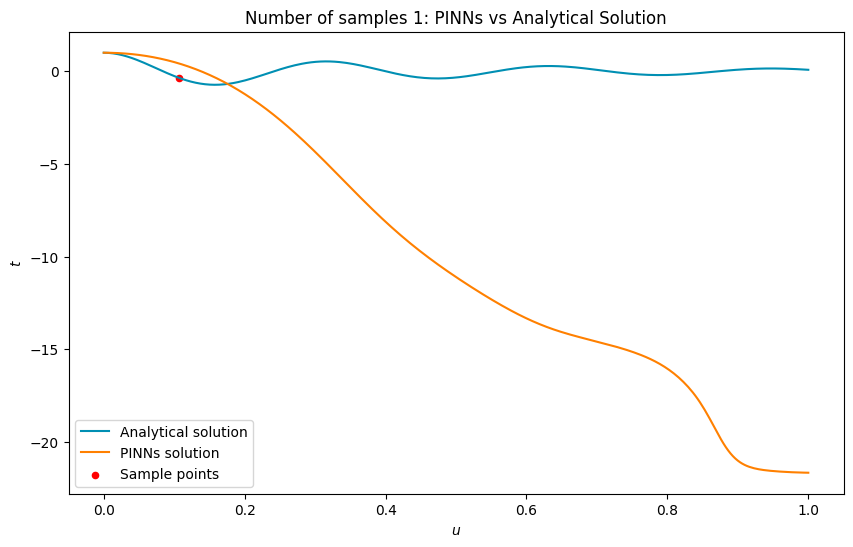

For 1 samples, the loss is 152.9942322223051


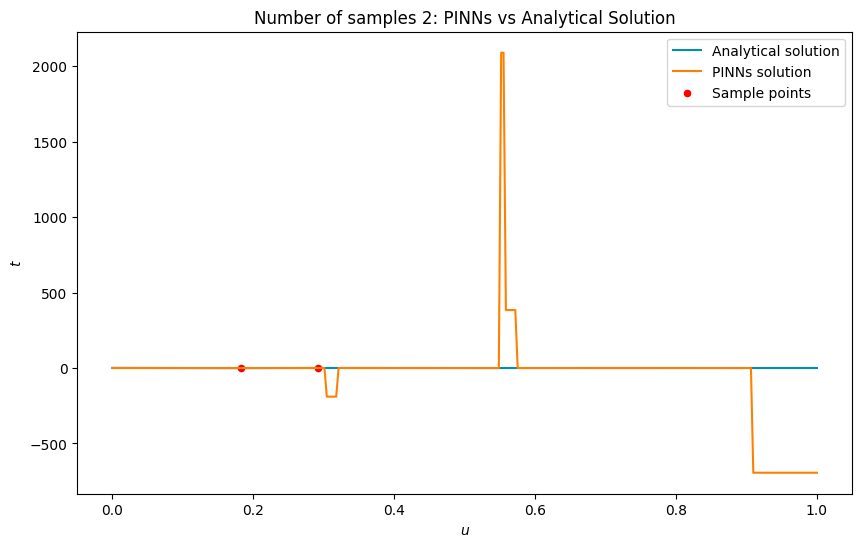

For 2 samples, the loss is 77173.21763621486


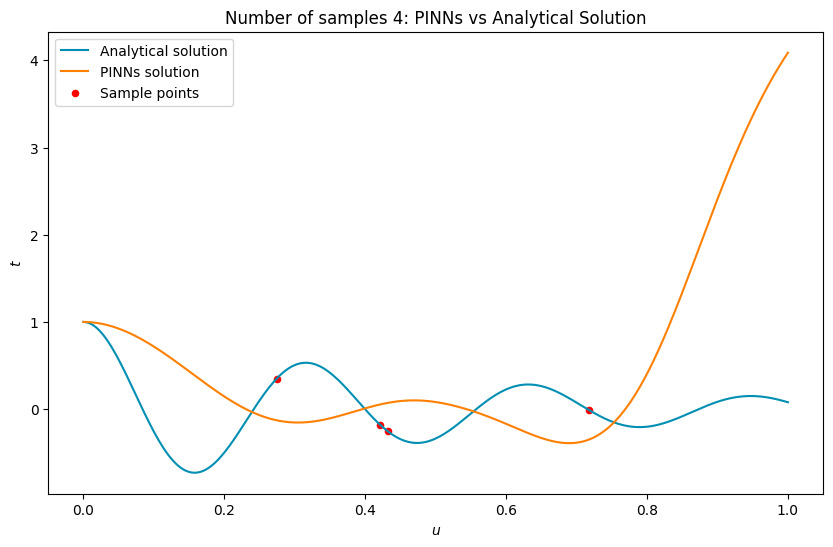

For 4 samples, the loss is 1.5370006448858582


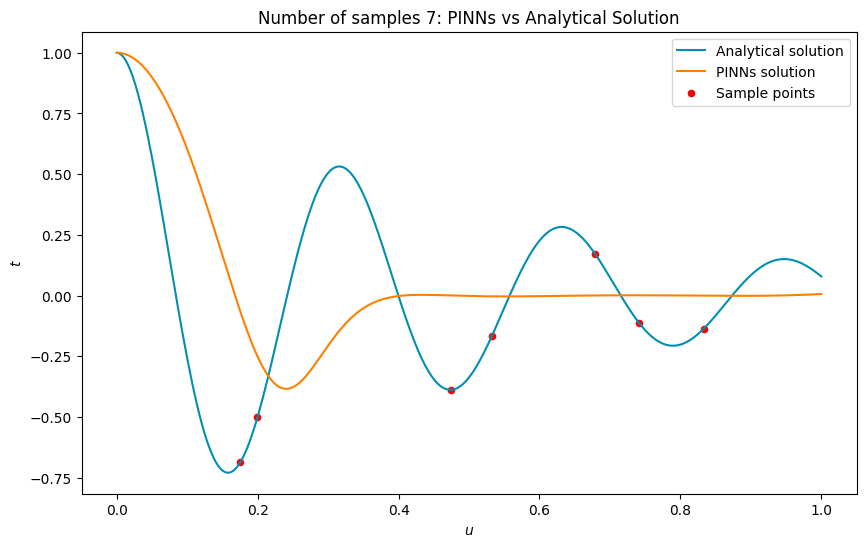

For 7 samples, the loss is 0.15500125101223544


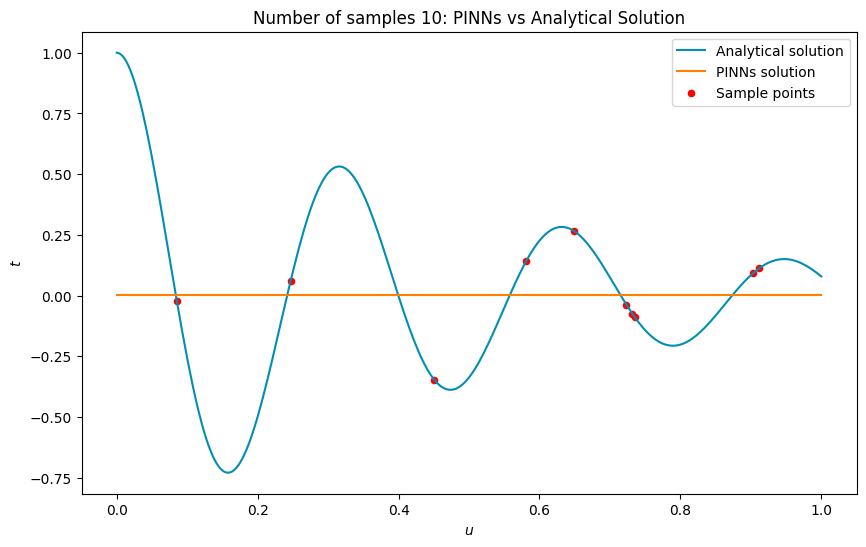

For 10 samples, the loss is 0.12914232991595526


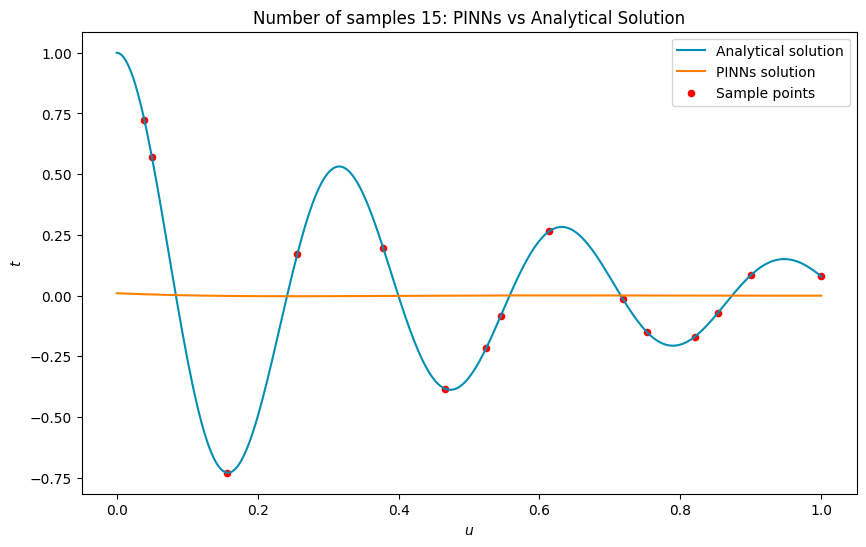

For 15 samples, the loss is 0.12844505207220328


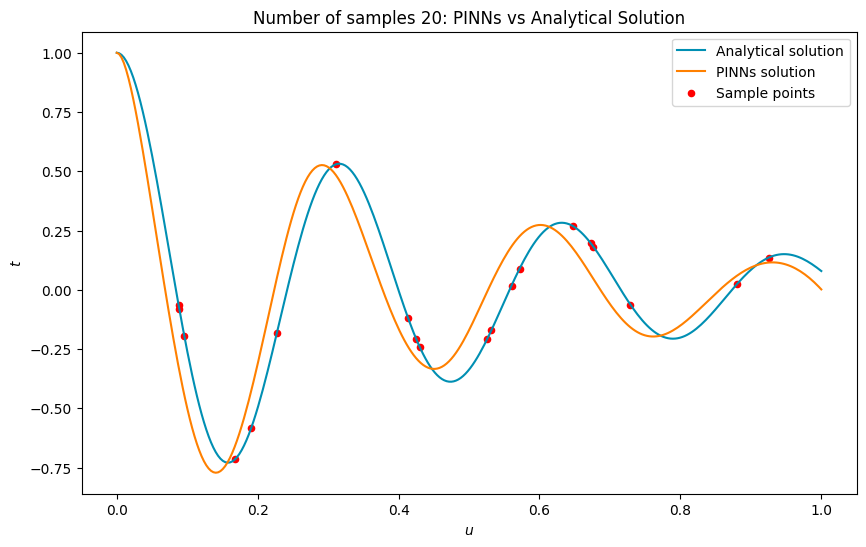

For 20 samples, the loss is 0.01779279480090958


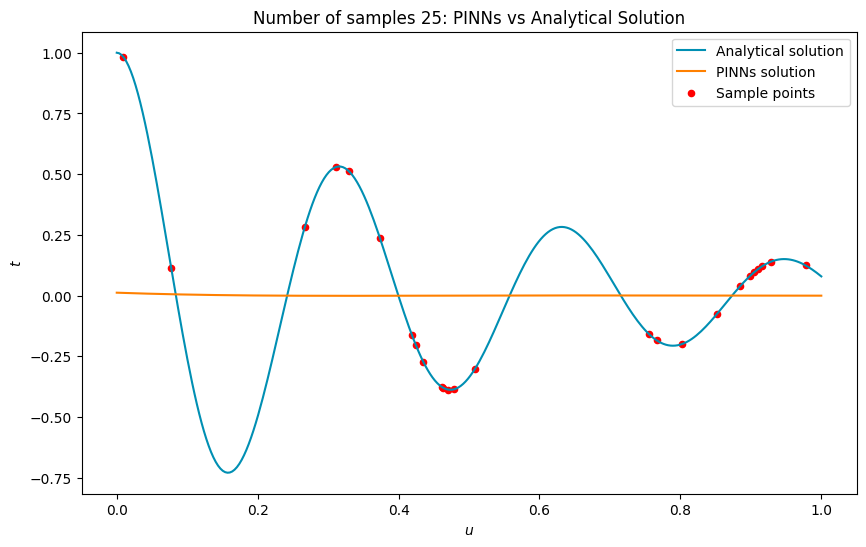

For 25 samples, the loss is 0.12847523769760286


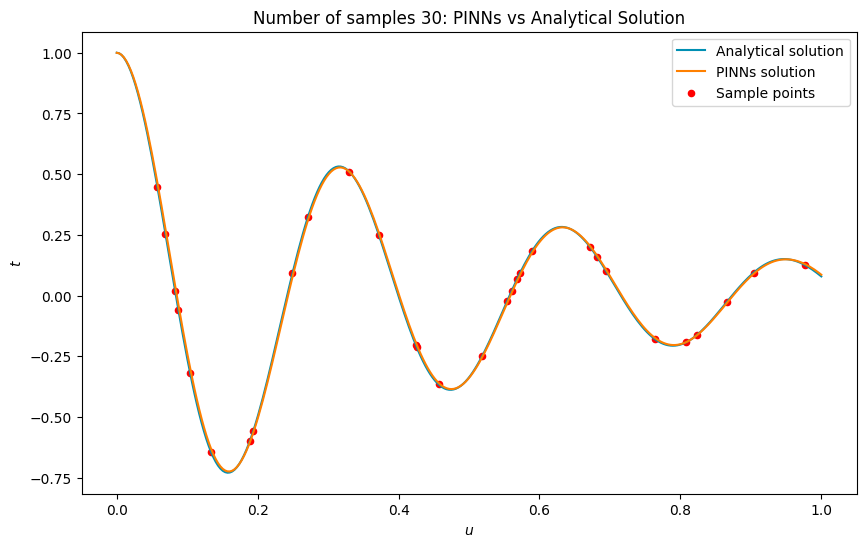

For 30 samples, the loss is 7.527630820471785e-05


In [ ]:
#n_max_sample = 1000
#n_test_sample = 300

E_values = []
n_samples_values = [1,2,4,7,10,15,20,25,30]

for num_samples in n_samples_values:
    num_samples_to_tensor = torch.tensor(num_samples)
    u_pred = pinn_model_predict(n_samples=num_samples_to_tensor)
    E = compute_MSE(u_pred,u_test_cuda)
    E_values.append(E)
    print(f"For {num_samples} samples, the loss is {E}")

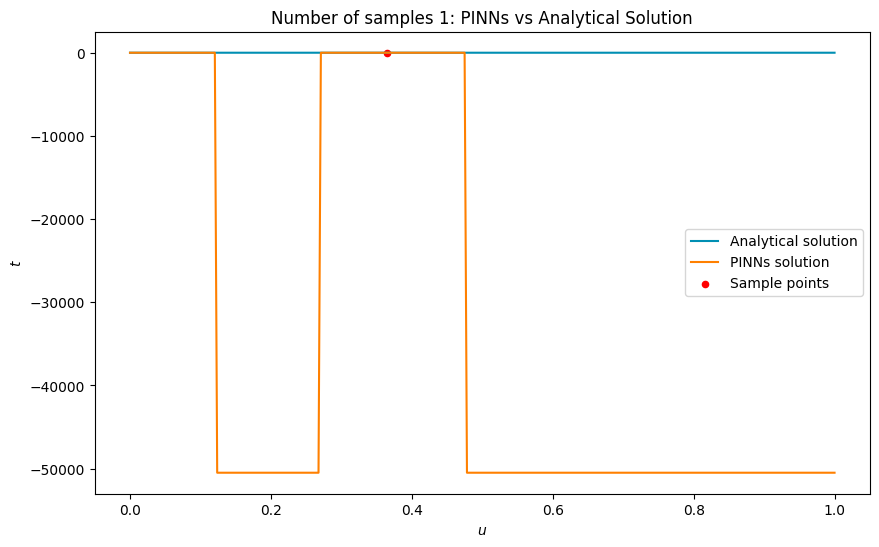

For 1 samples, the loss is 1707967664.1305294


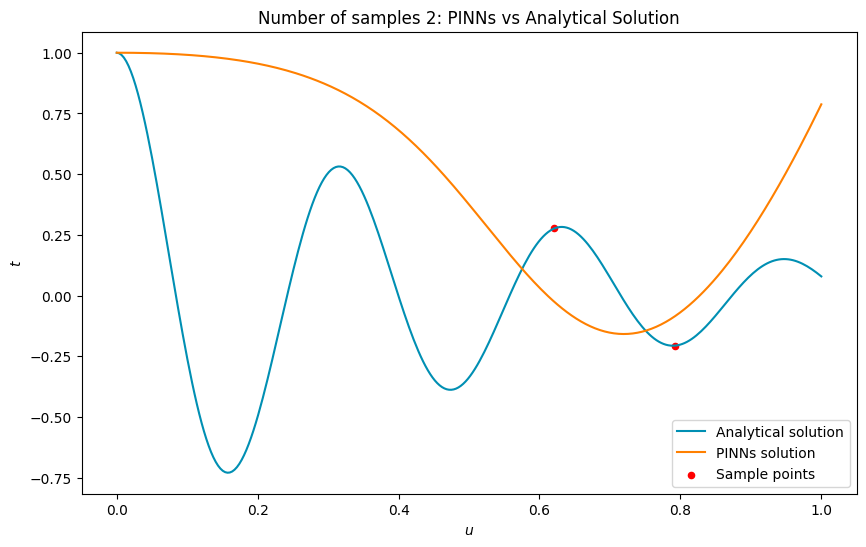

For 2 samples, the loss is 0.505164404485253


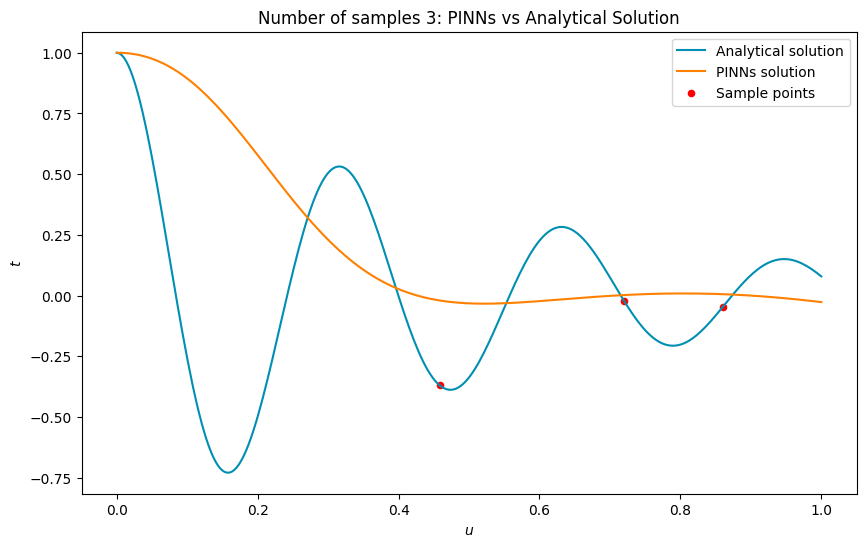

For 3 samples, the loss is 0.2765393955780068


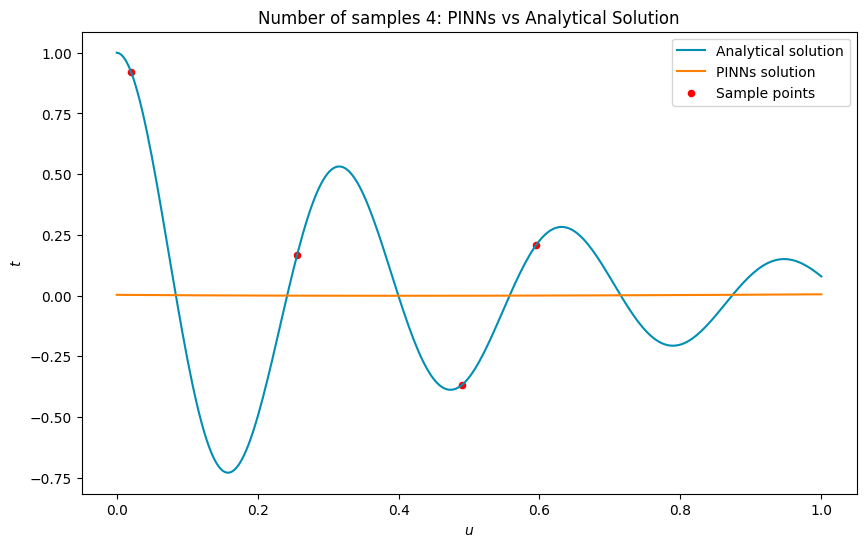

For 4 samples, the loss is 0.12893192223558553


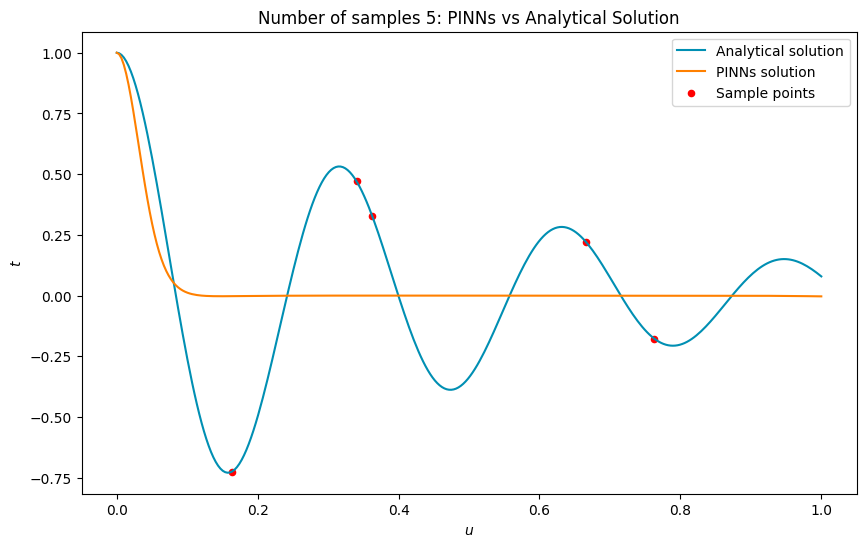

For 5 samples, the loss is 0.08952873730730787


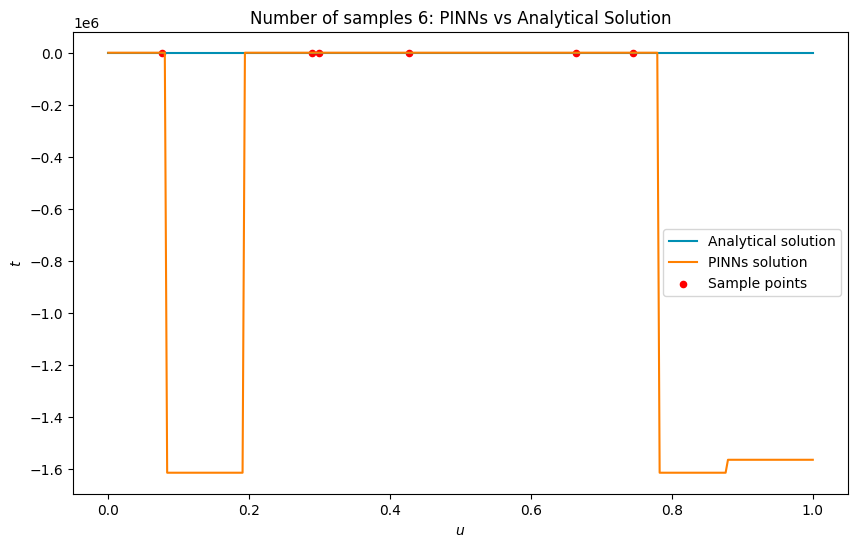

For 6 samples, the loss is 841542424262.0598


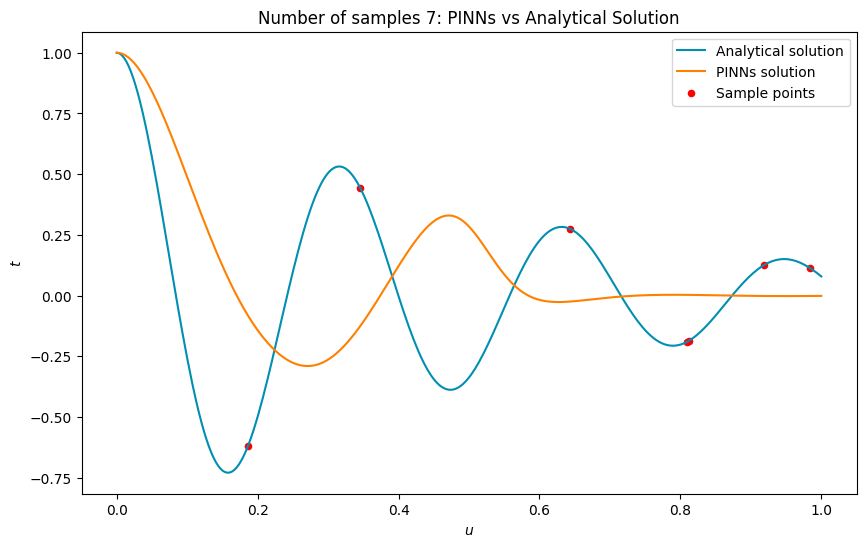

For 7 samples, the loss is 0.17790724825713938


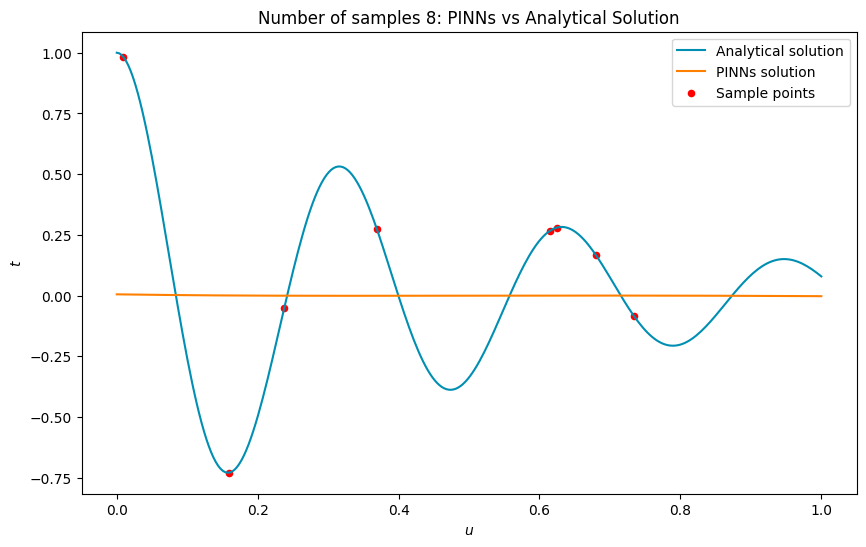

For 8 samples, the loss is 0.12888684308624201


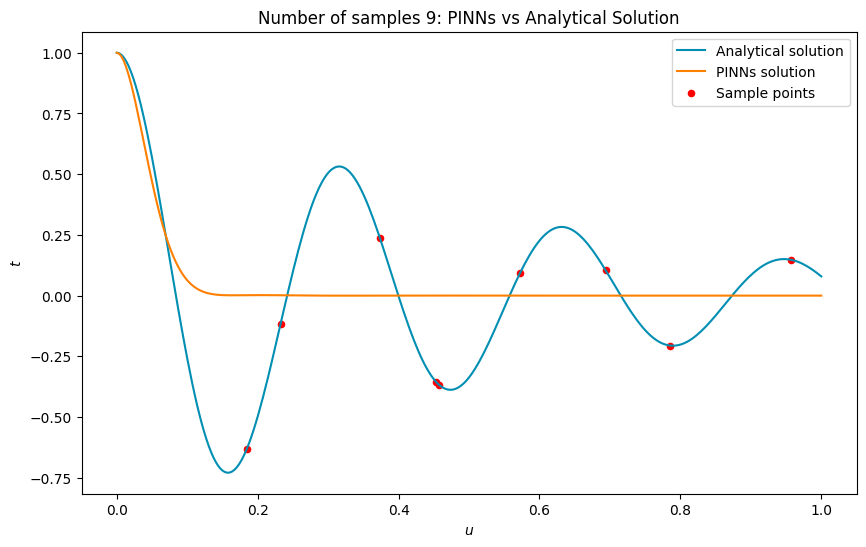

For 9 samples, the loss is 0.08895580960639139


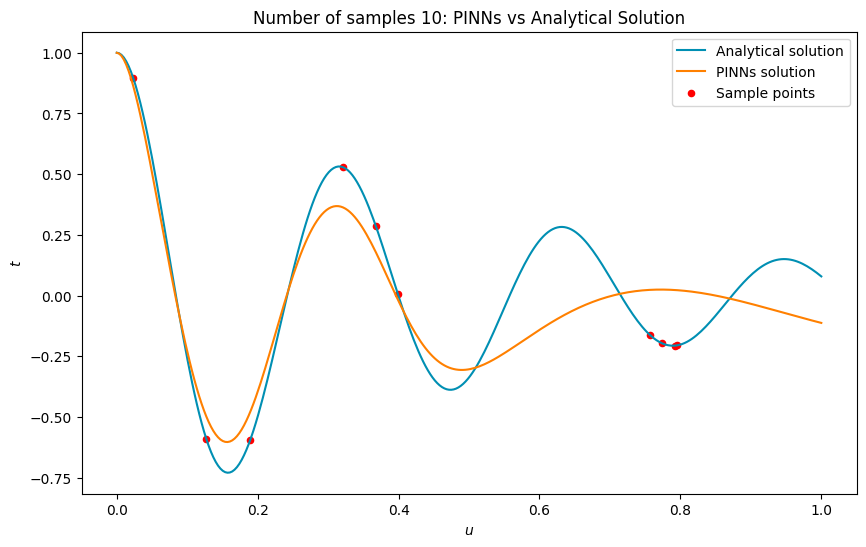

For 10 samples, the loss is 0.0264740418255061


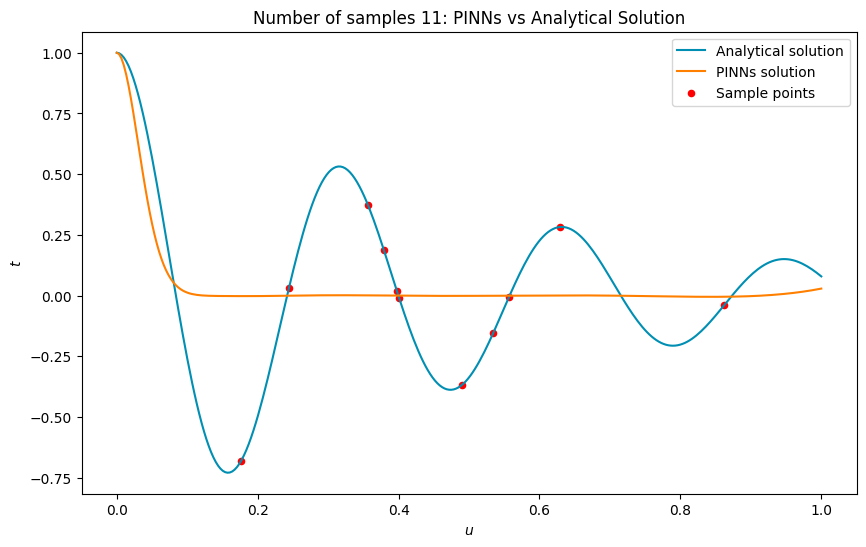

For 11 samples, the loss is 0.08899740240000928


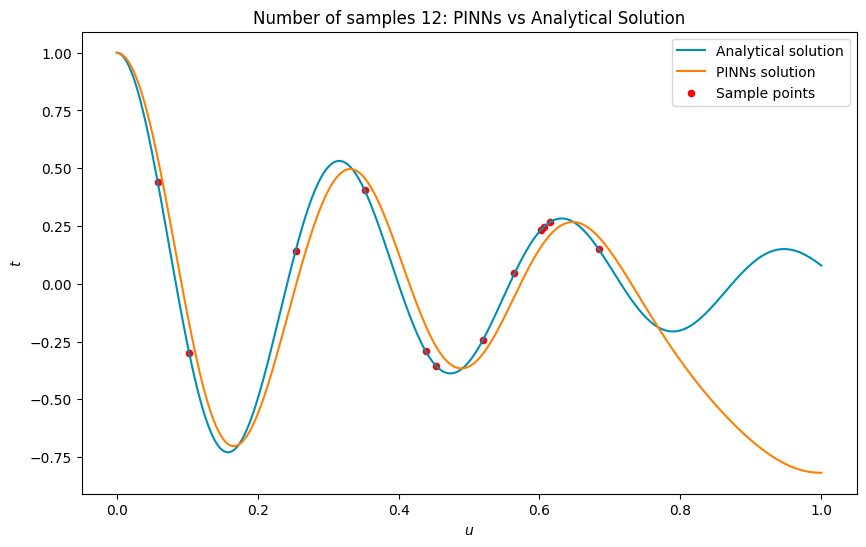

For 12 samples, the loss is 0.11062606905218751


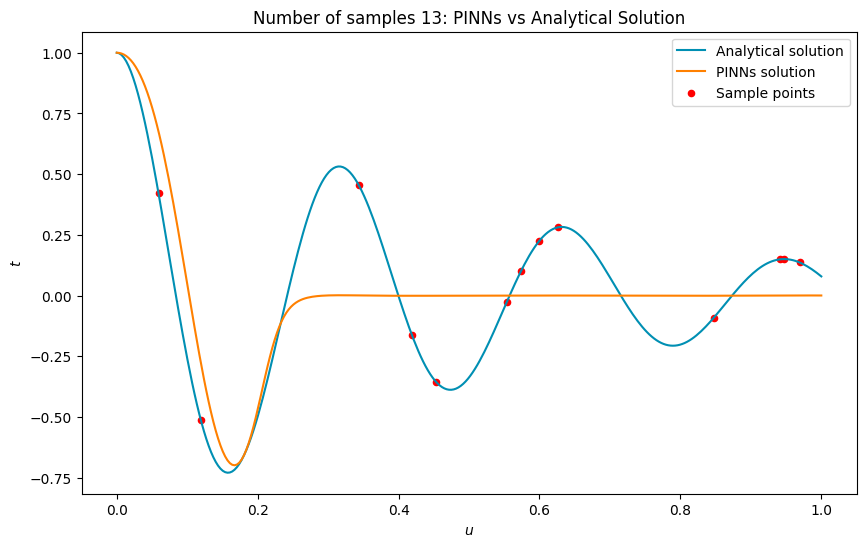

For 13 samples, the loss is 0.05266072966167175


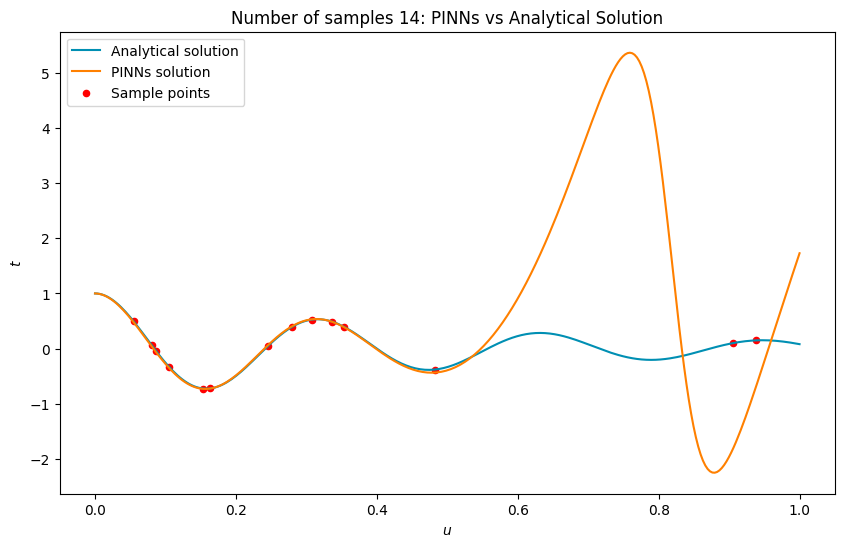

For 14 samples, the loss is 3.5147517298853113


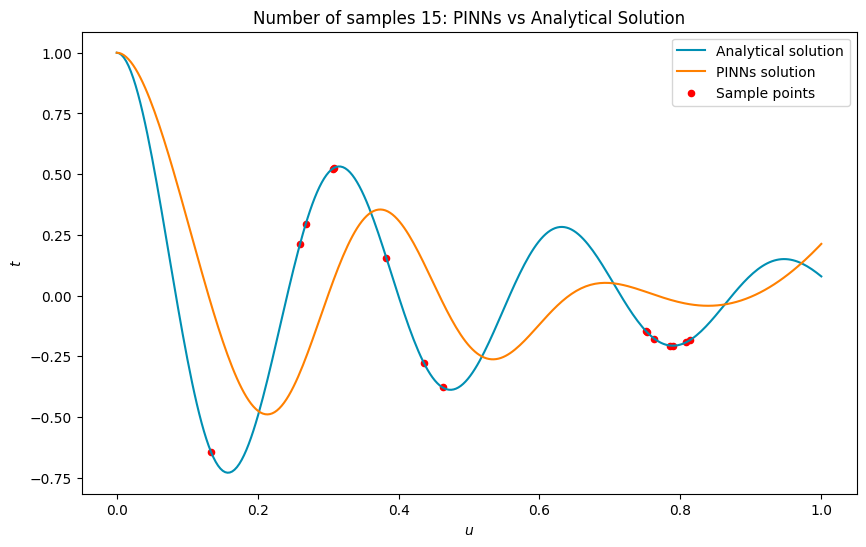

For 15 samples, the loss is 0.08553006790479753


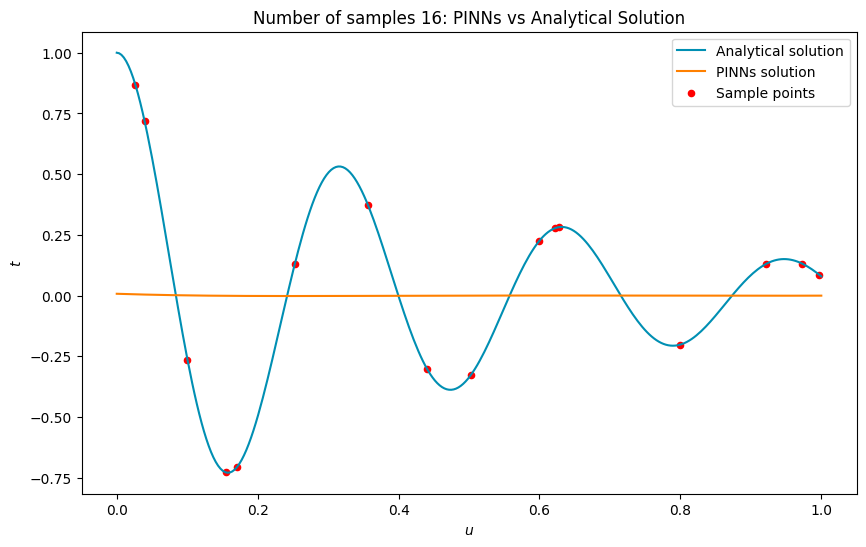

For 16 samples, the loss is 0.12862252624981446


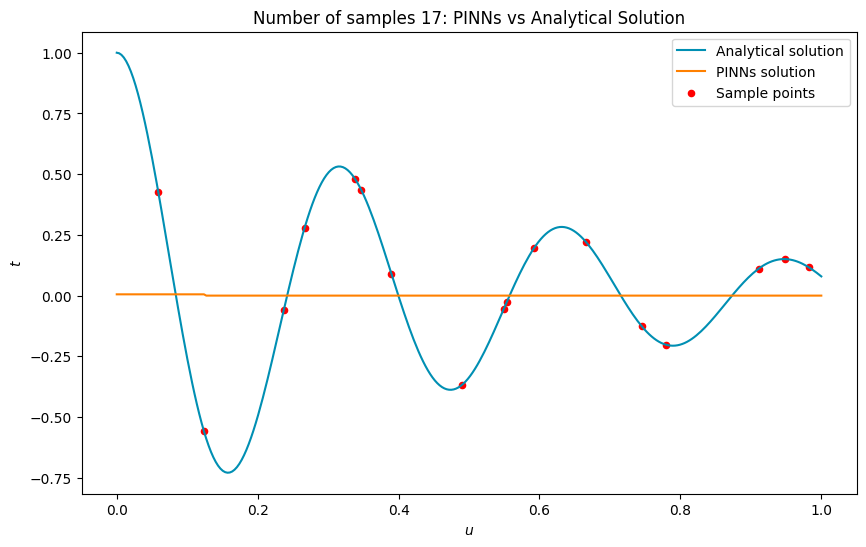

For 17 samples, the loss is 0.12873514792601304


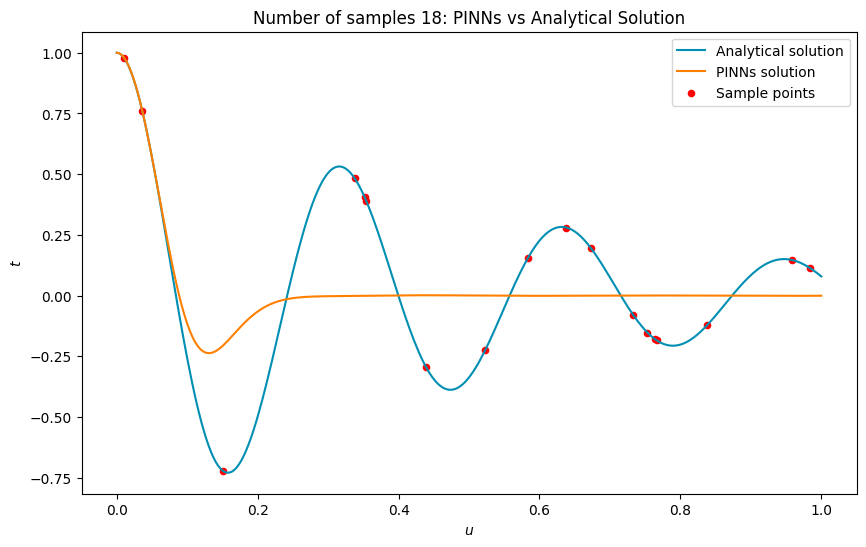

For 18 samples, the loss is 0.06875904659884796


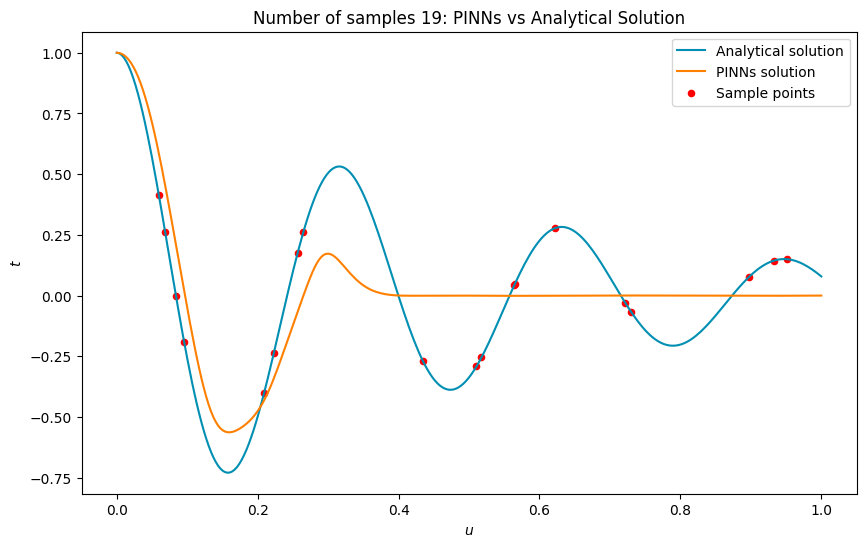

For 19 samples, the loss is 0.042831531872876825


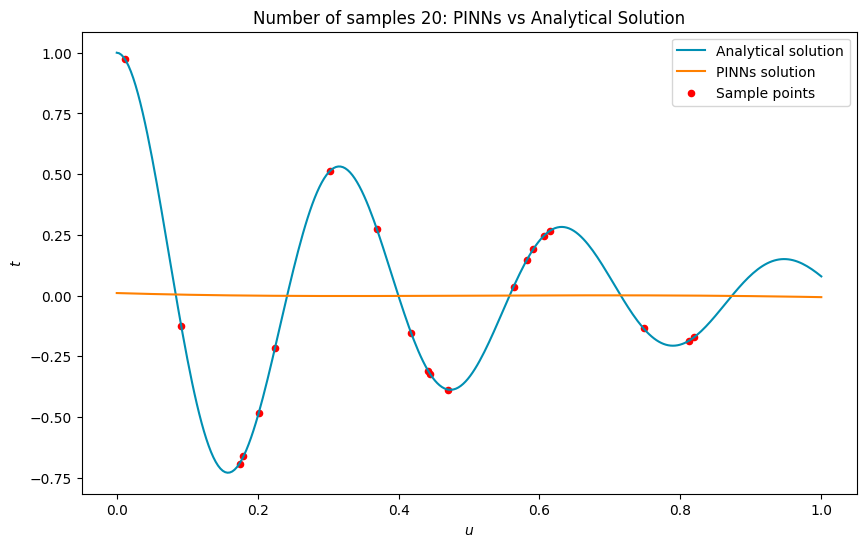

For 20 samples, the loss is 0.12863909835558116


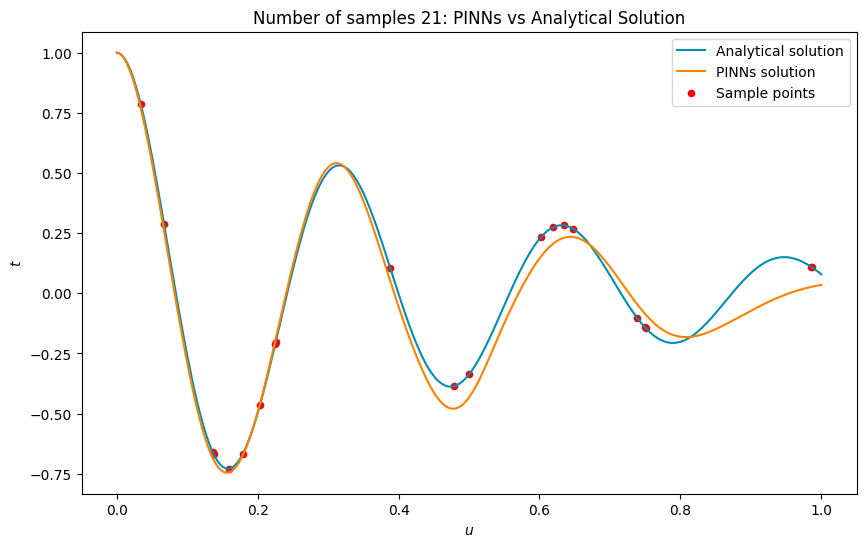

For 21 samples, the loss is 0.004646334958980833


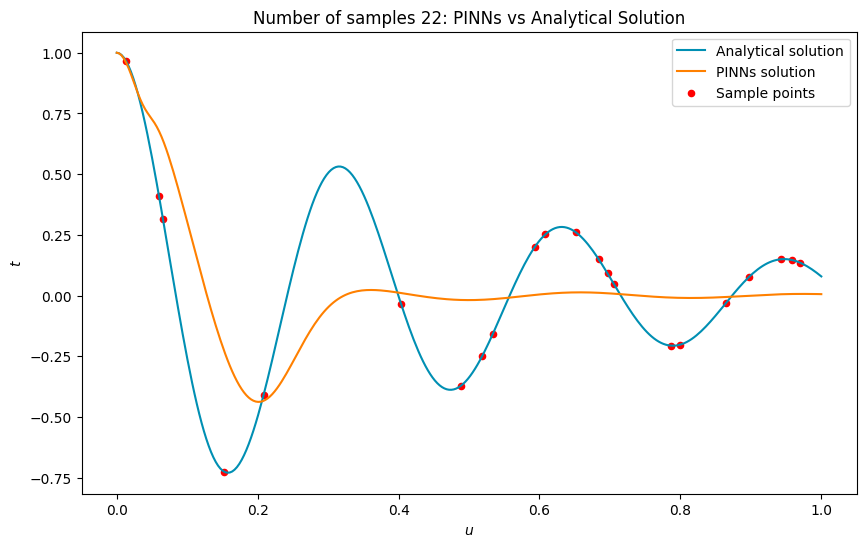

For 22 samples, the loss is 0.08178114289048942


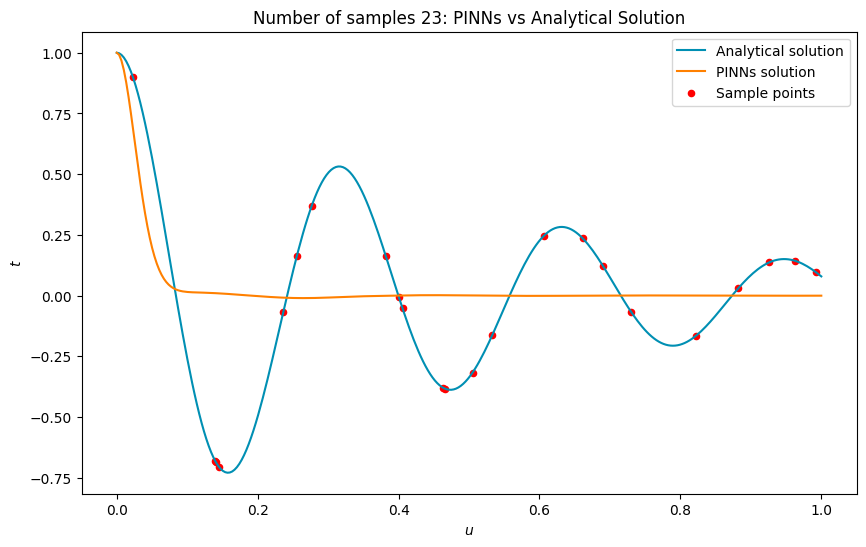

For 23 samples, the loss is 0.0937612770747684


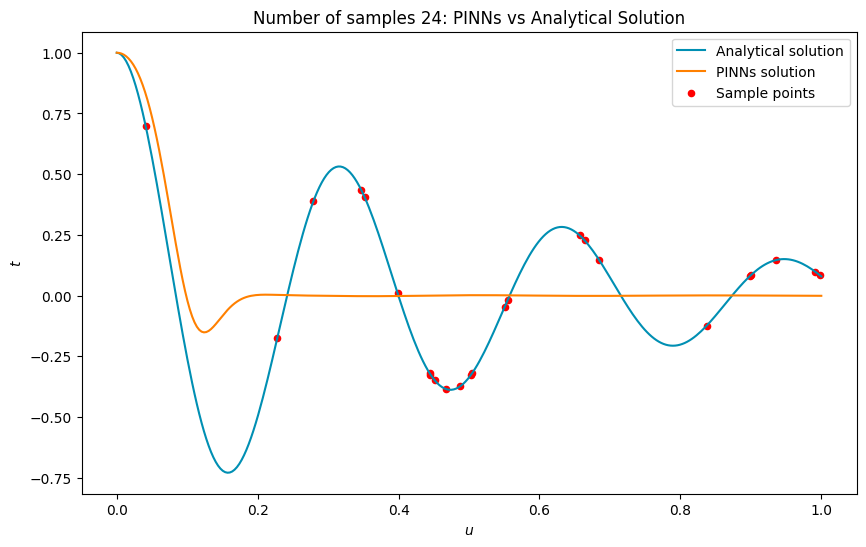

For 24 samples, the loss is 0.08189568865523536


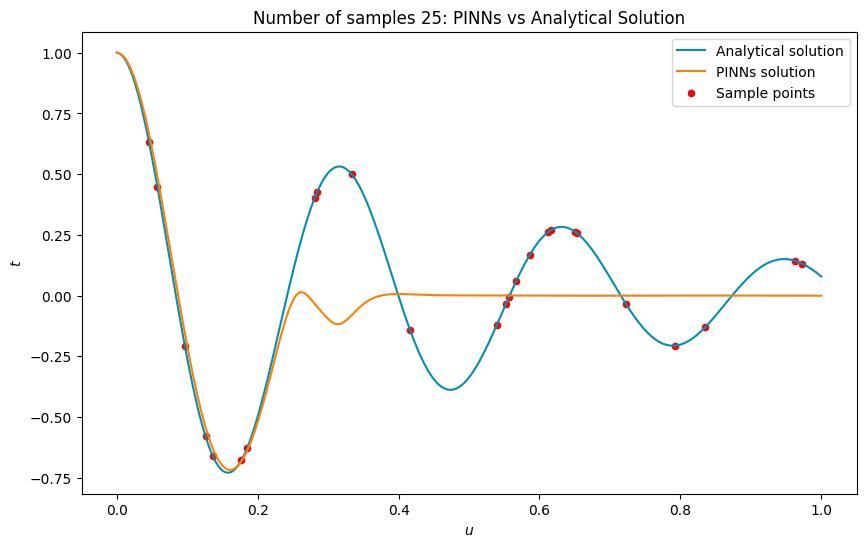

For 25 samples, the loss is 0.05241493968792384


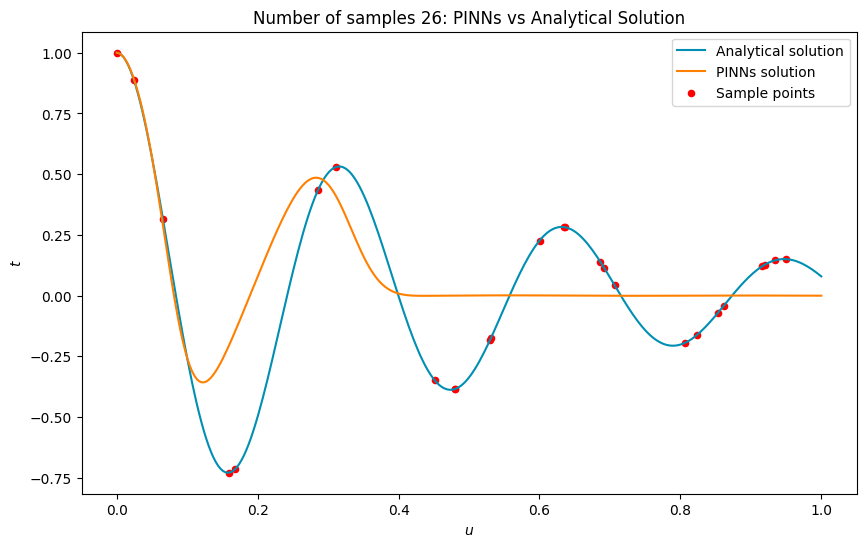

For 26 samples, the loss is 0.05772526021978851


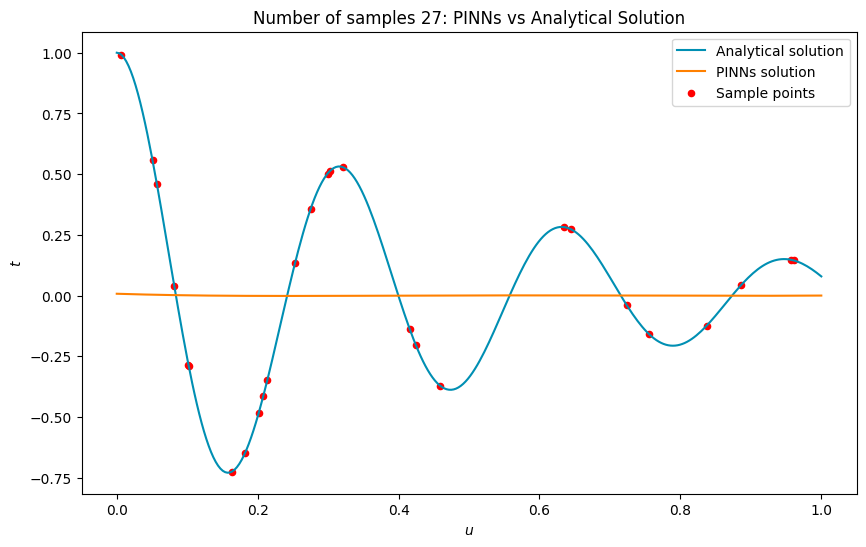

For 27 samples, the loss is 0.12862088384718676


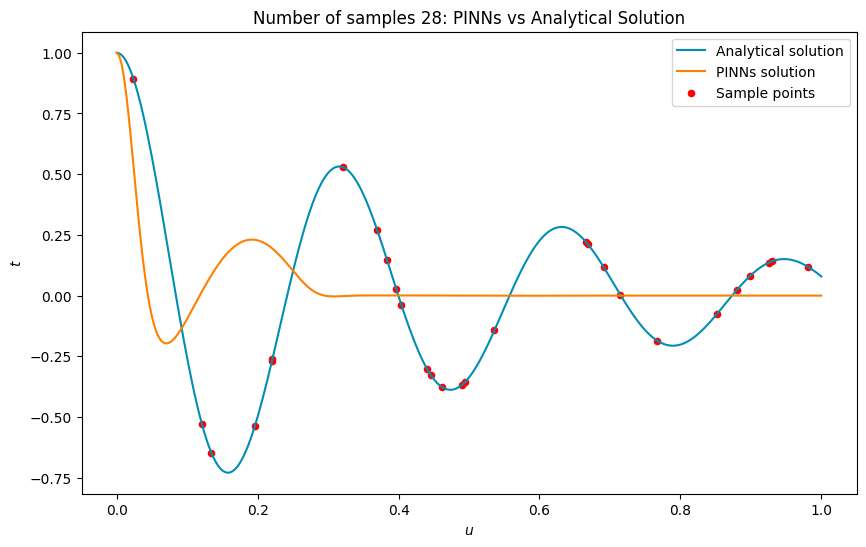

For 28 samples, the loss is 0.12827649376688988


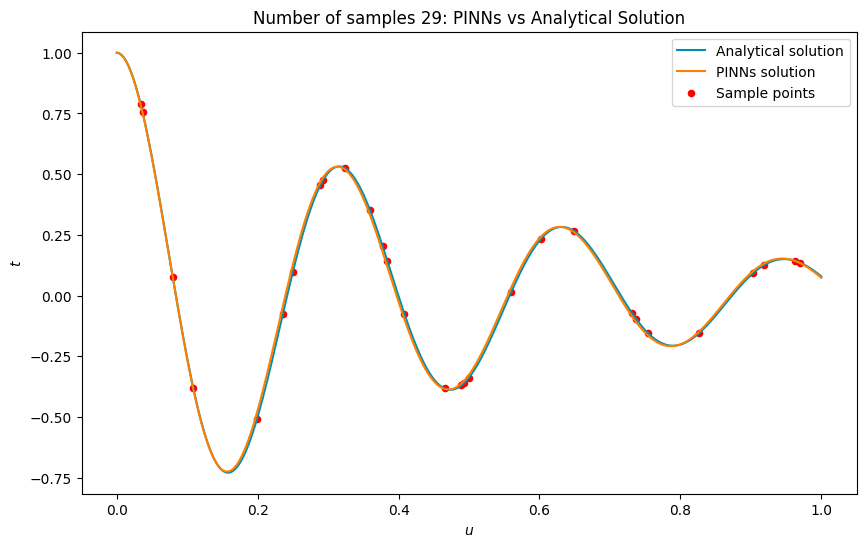

For 29 samples, the loss is 0.00018184992742849572


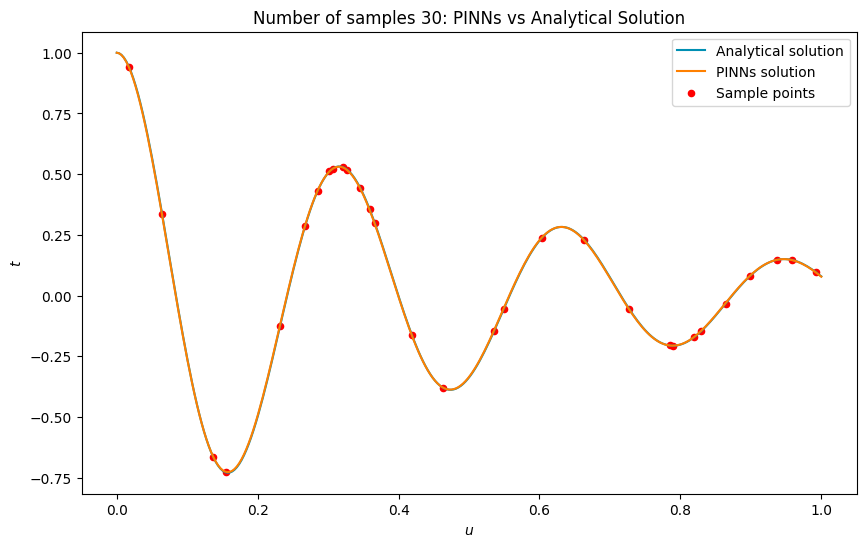

For 30 samples, the loss is 6.0653028841400044e-06


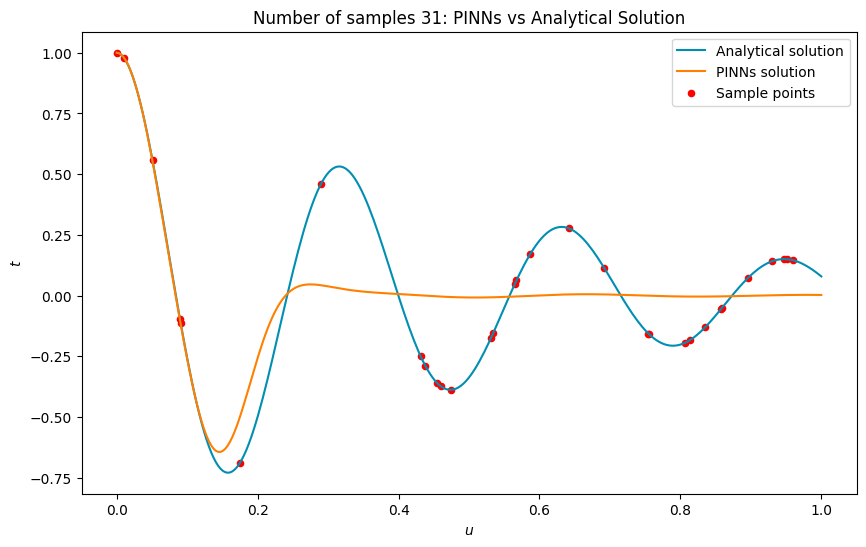

For 31 samples, the loss is 0.044717546960392


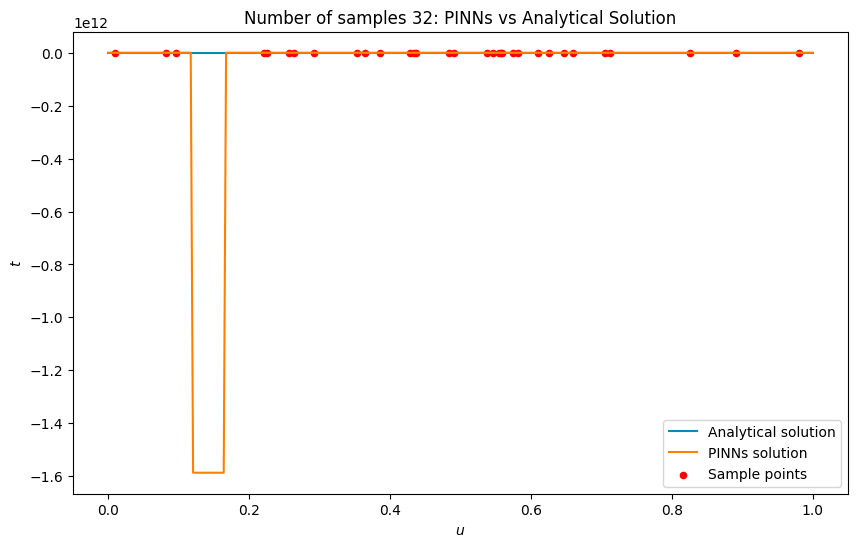

For 32 samples, the loss is 1.1753958476053945e+23


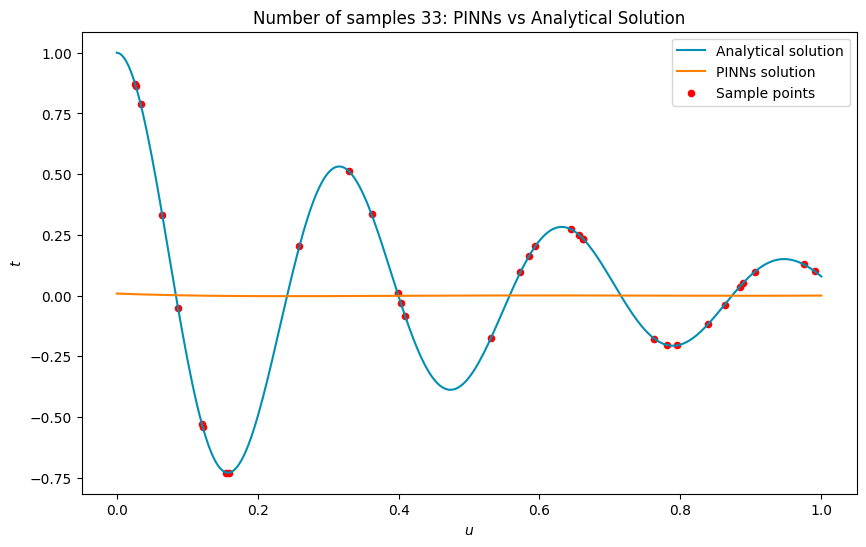

For 33 samples, the loss is 0.1285391455227239


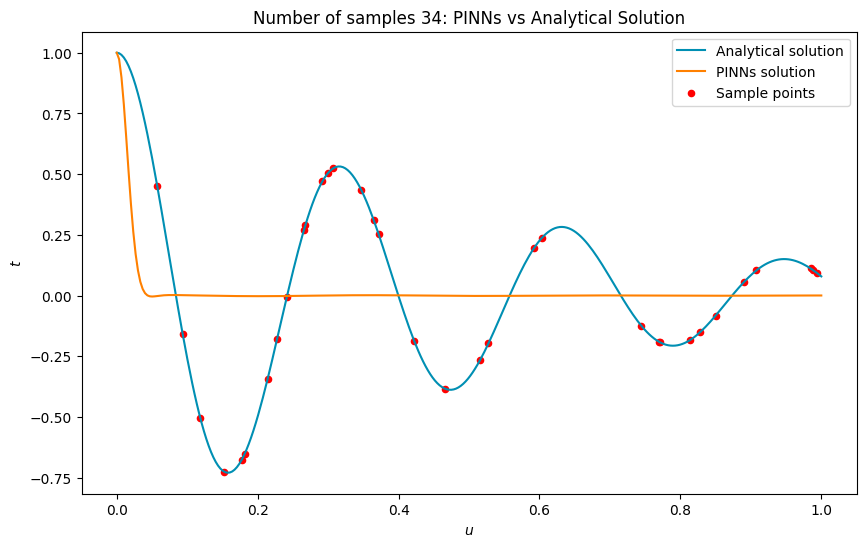

For 34 samples, the loss is 0.10561953761896013


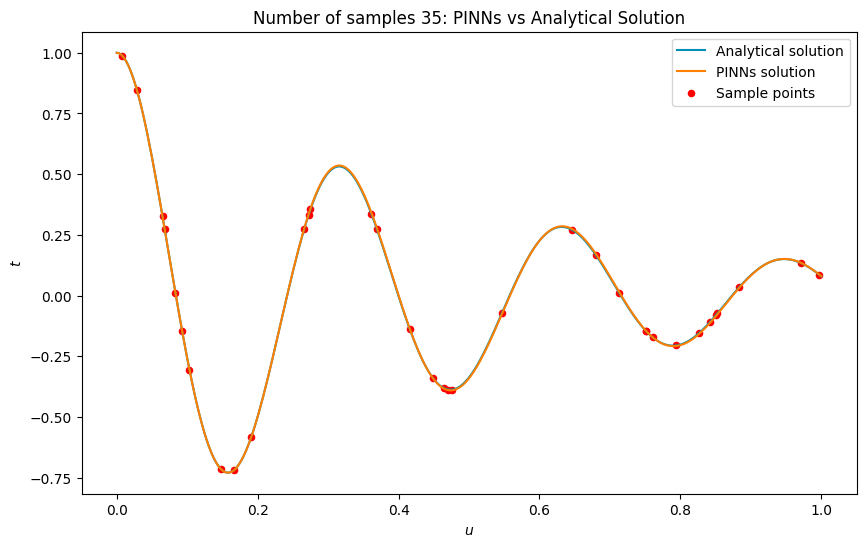

For 35 samples, the loss is 6.56029377214942e-06


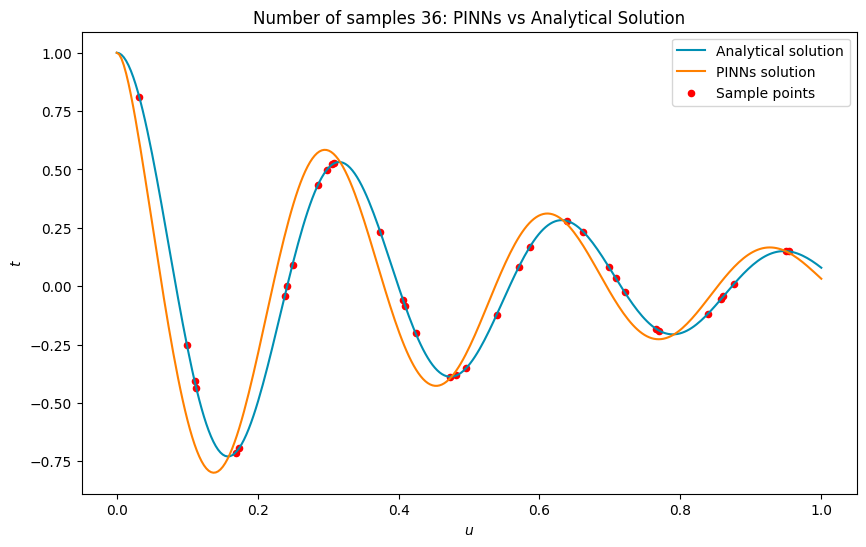

For 36 samples, the loss is 0.02025463787497745


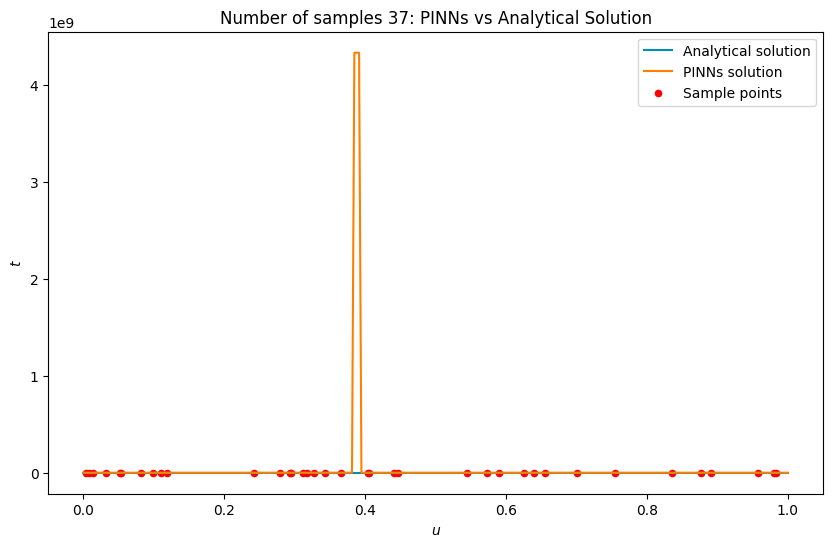

For 37 samples, the loss is 1.8737657585727248e+17


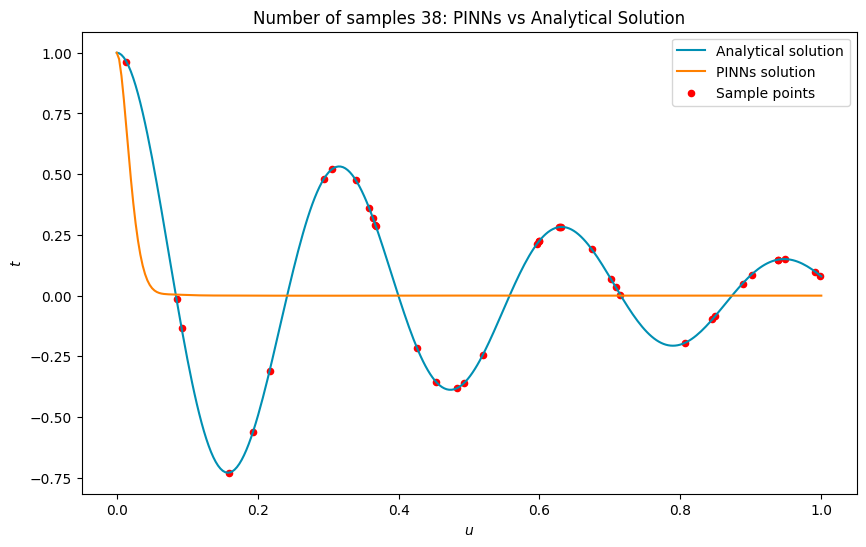

For 38 samples, the loss is 0.10185008388146868


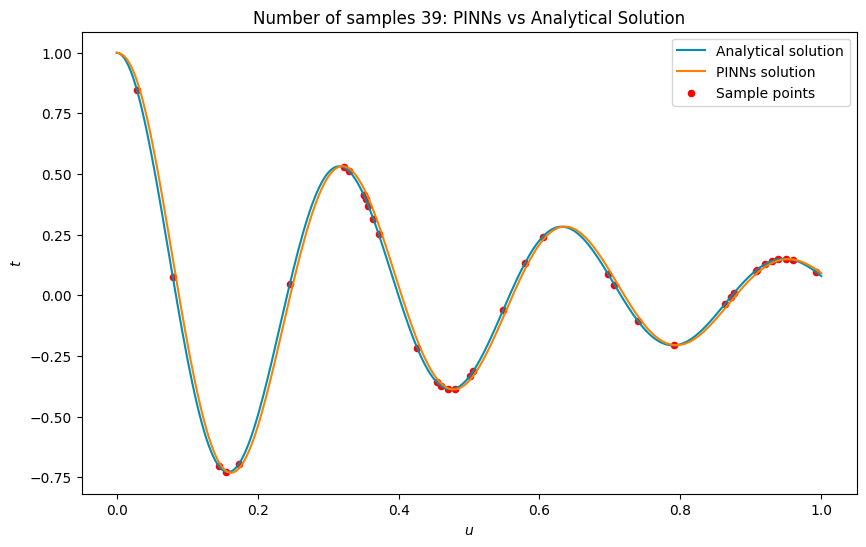

For 39 samples, the loss is 0.0009625112879860393


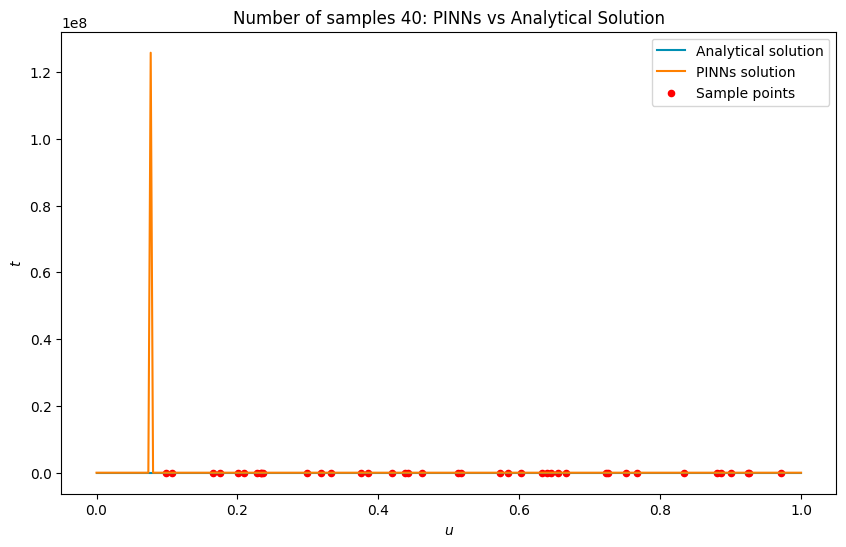

For 40 samples, the loss is 52705983415168.1


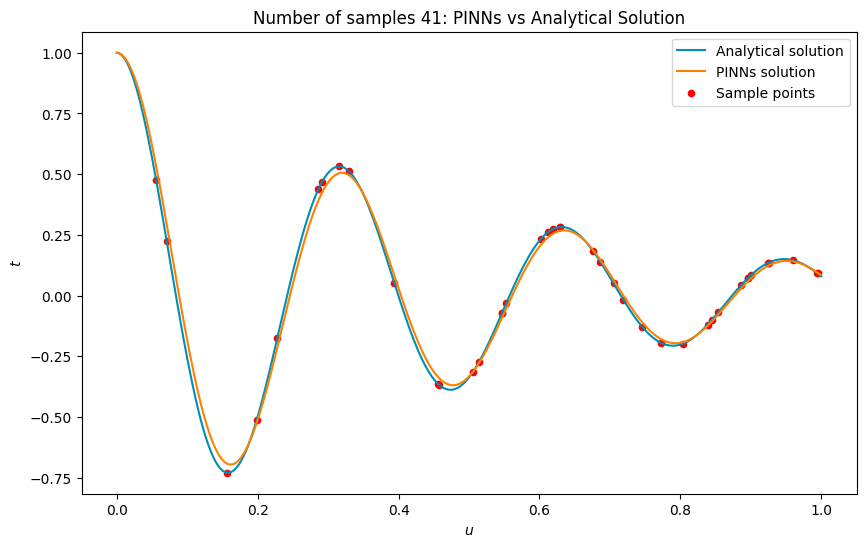

For 41 samples, the loss is 0.0009034428927102729


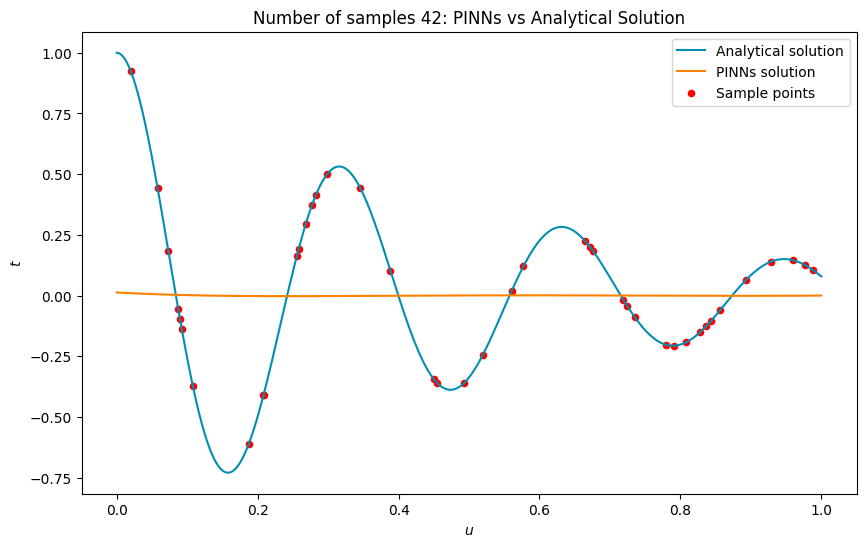

For 42 samples, the loss is 0.12825694114034658


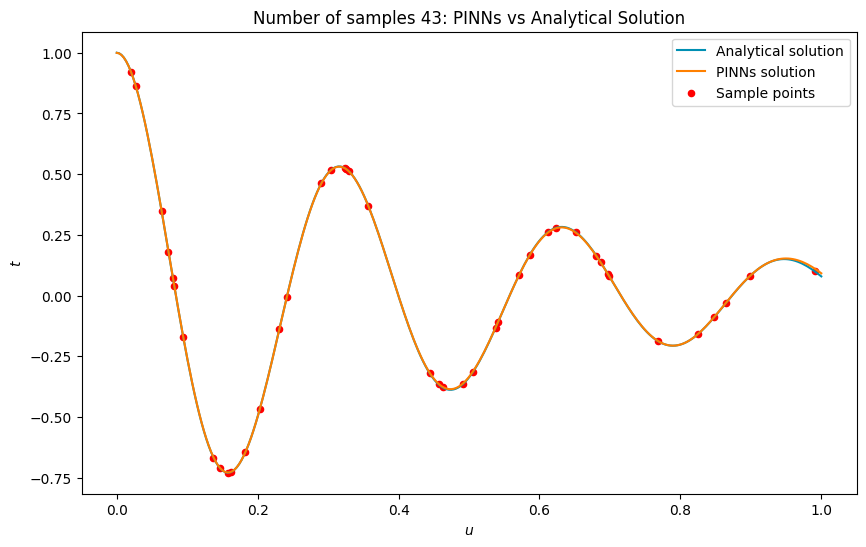

For 43 samples, the loss is 4.775706790573465e-06


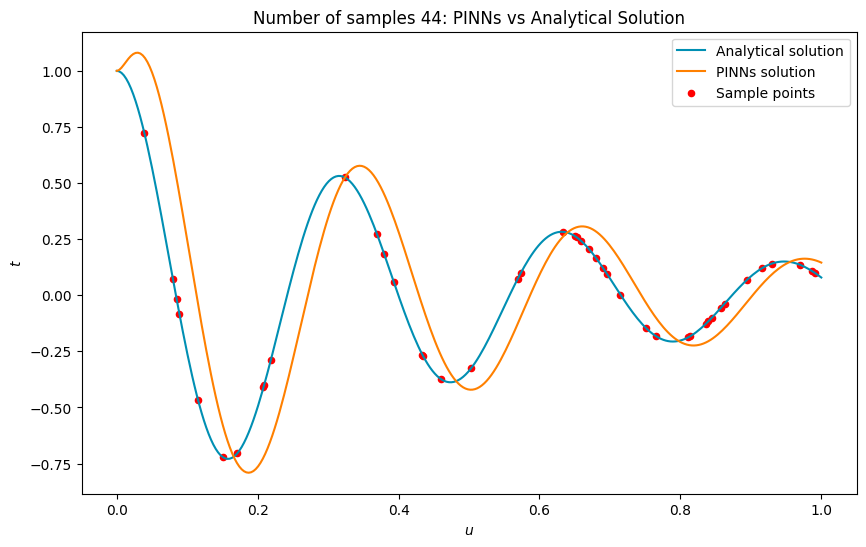

For 44 samples, the loss is 0.047168756683318123


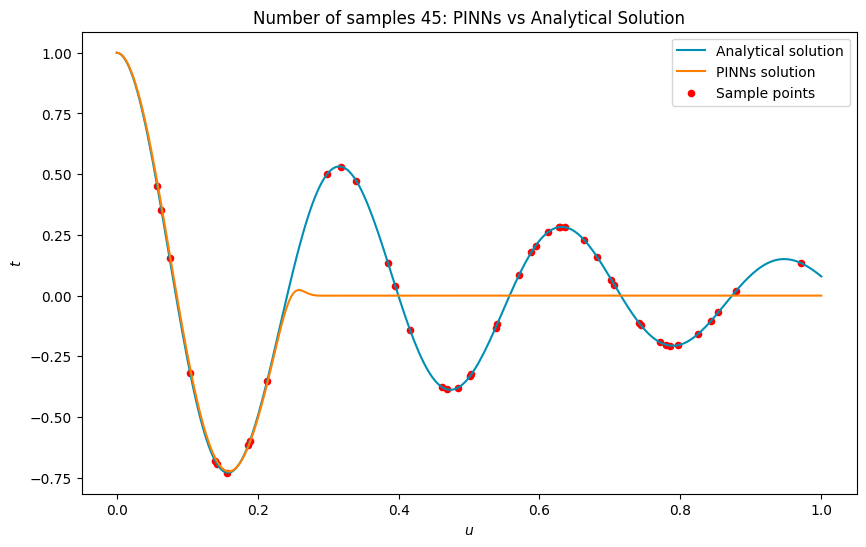

For 45 samples, the loss is 0.04516270145145413


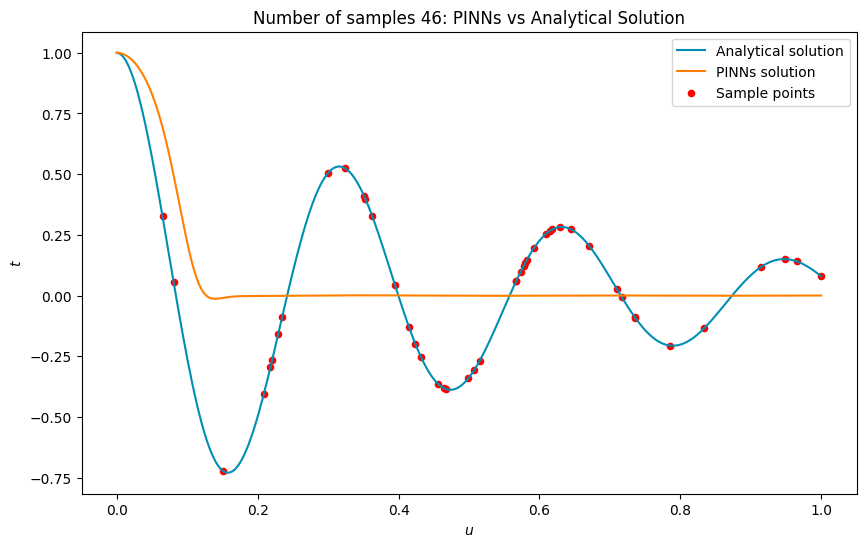

For 46 samples, the loss is 0.09682523063241845


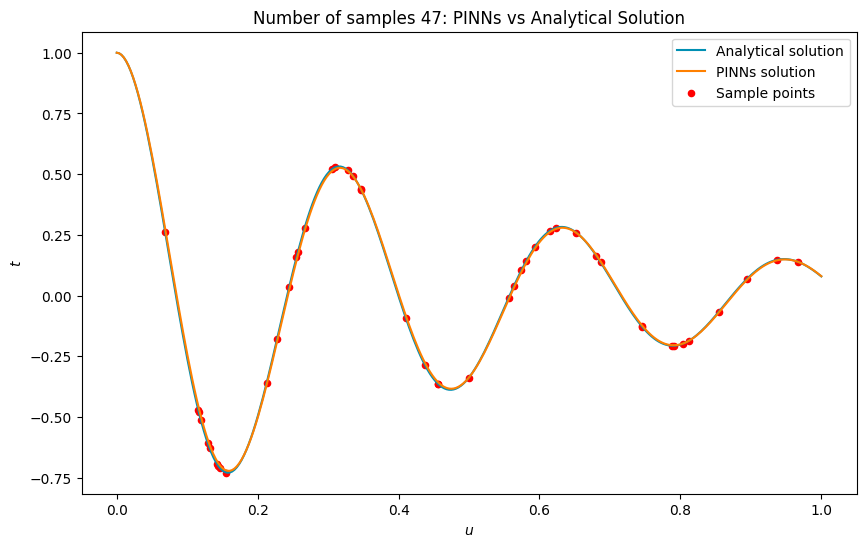

For 47 samples, the loss is 5.2401041308227376e-05


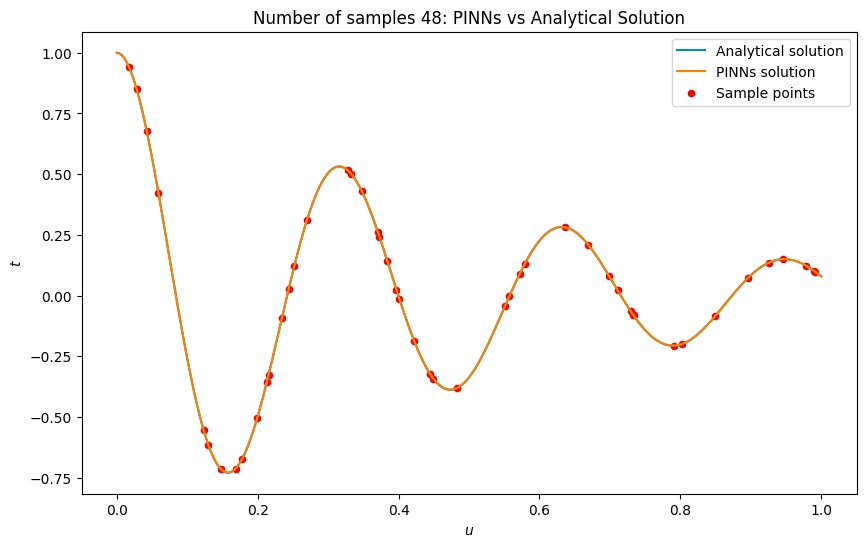

For 48 samples, the loss is 2.544984976301382e-07


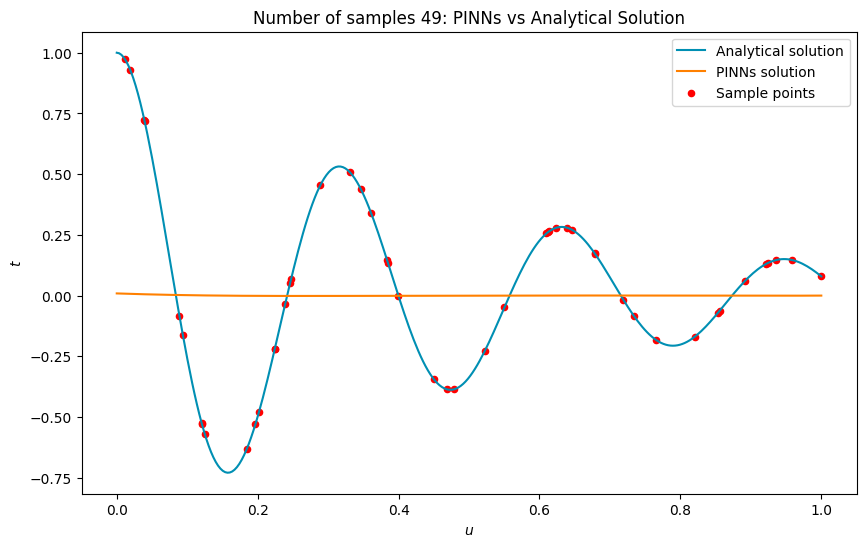

For 49 samples, the loss is 0.12855757798456363


In [ ]:
E_values_2 = []
#_samples_values = [1,2,4,7,10,15,20,25,30]
n_sample = 50
for num_samples in range(1, n_sample):
    num_samples_to_tensor = torch.tensor(num_samples)
    u_pred = pinn_model_predict(n_samples=num_samples_to_tensor)
    E = compute_MSE(u_pred,u_test_cuda)
    E_values.append(E)
    print(f"For {num_samples} samples, the loss is {E}")

In [ ]:
E_values_numpy = [E_value.item() for E_value in E_values]
E_values_numpy_processed = [values for values in E_values_numpy if values < 200]
E_values_numpy_processed

[152.9942322223051,
 1.5370006448858582,
 0.15500125101223544,
 0.12914232991595526,
 0.12844505207220328,
 0.01779279480090958,
 0.12847523769760286,
 7.527630820471785e-05,
 0.505164404485253,
 0.2765393955780068,
 0.12893192223558553,
 0.08952873730730787,
 0.17790724825713938,
 0.12888684308624201,
 0.08895580960639139,
 0.0264740418255061,
 0.08899740240000928,
 0.11062606905218751,
 0.05266072966167175,
 3.5147517298853113,
 0.08553006790479753,
 0.12862252624981446,
 0.12873514792601304,
 0.06875904659884796,
 0.042831531872876825,
 0.12863909835558116,
 0.004646334958980833,
 0.08178114289048942,
 0.0937612770747684,
 0.08189568865523536,
 0.05241493968792384,
 0.05772526021978851,
 0.12862088384718676,
 0.12827649376688988,
 0.00018184992742849572,
 6.0653028841400044e-06,
 0.044717546960392,
 0.1285391455227239,
 0.10561953761896013,
 6.56029377214942e-06,
 0.02025463787497745,
 0.10185008388146868,
 0.0009625112879860393,
 0.0009034428927102729,
 0.12825694114034658,
 4.7757

In [ ]:
np.arange(1,len(E_values_numpy_processed+1))

TypeError: can only concatenate list (not "int") to list

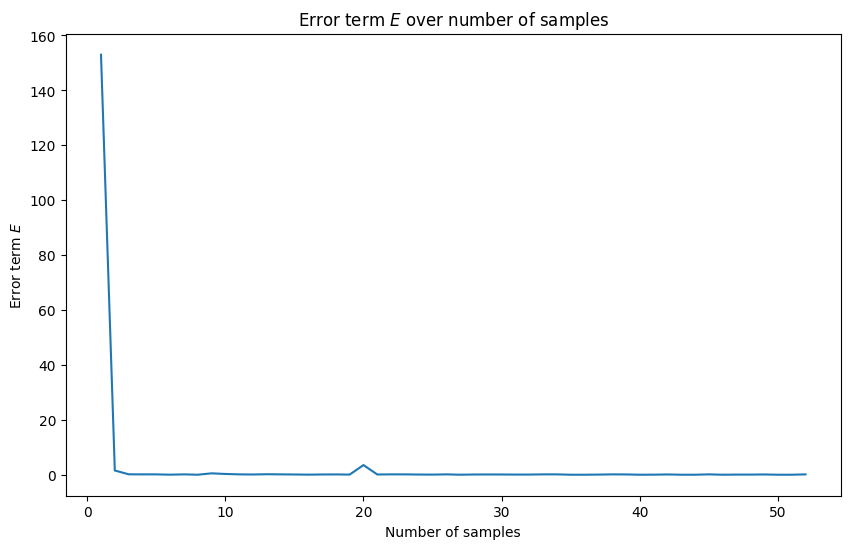

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(range(1,len(E_values_numpy_processed)+1),E_values_numpy_processed, label="Error term $E$")
plt.title("Error term $E$ over number of samples")
plt.xlabel("Number of samples")
plt.ylabel("Error term $E$")
plt.show()

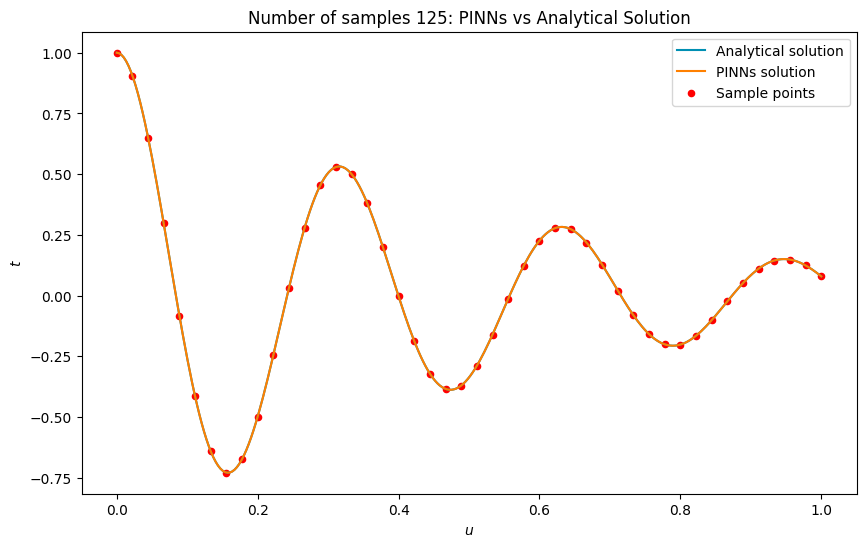

In [ ]:
pinn = FCN(1, 1,32,3).double().to(device)
#optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)
optimizer = optim.LBFGS(pinn.parameters(), lr=0.1, max_iter=500)
epochs = 5000
lambda1, lambda2 = 1e-1, 1e-2

t_pde_cuda = torch.linspace(0,1,46).view(-1,1).double().to(device)
t_pde_cuda = t_pde_cuda * t_max # scale with [0,t_max]
t_pde_cuda.requires_grad = True
# for visualization
t_pde_cpu = t_pde_cuda.cpu()
t_pde_numpy = t_pde_cpu.detach().numpy()
u_pde_numpy_exact = analytical_solution(t_pde_numpy, k, mu, m)

t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)
t_boundary = t_boundary.double().to(device)



for i in range(epochs):
    #pinn.train()
    def closure():
      optimizer.zero_grad()
      """
      # compute data loss
      u_pred = pinn(t_data_to_tensor)
      data_residual = u_pred-u_data_to_tensor
      data_loss = torch.mean(data_residual**2) # (1/N) * torch.sum(data_residual**2) # = mean
      """
      # compute boundary loss
      u = pinn(t_boundary)
      loss1 = (torch.squeeze(u) - 1)**2
      dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
      loss2 = (torch.squeeze(dudt) - 0)**2
      # compute pde loss
      u_pred = pinn(t_pde_cuda)
      du_dt = torch.autograd.grad(u_pred, t_pde_cuda, torch.ones_like(u_pred).to(device),create_graph=True)[0]
      d2u_dt2 = torch.autograd.grad(du_dt, t_pde_cuda, torch.ones_like(du_dt).to(device),create_graph=True)[0]
      loss3 = torch.mean((m*d2u_dt2+mu*du_dt+k*u_pred)**2) #(1/M) * torch.sum((m*d2u_dt2+mu*du_dt+k*u_pred)**2)
      total_loss = loss1 + lambda1*loss2 + lambda2*loss3
      total_loss.backward()
      return total_loss
      #print(f"Epoch {i}, loss {total_loss}")
    optimizer.step(closure)

# visualize random samples

u_test_pred_cuda = pinn(t_test_cuda)
u_test_pred_numpy =  u_test_pred_cuda.cpu().detach().numpy()

plt.figure(figsize=(10,6))
plt.plot(t_test, u_test, color=light_cyan,label="Analytical solution")
plt.plot(t_test, u_test_pred_numpy, color=light_orange,label="PINNs solution")
plt.title(f"Number of samples {n_samples}: PINNs vs Analytical Solution")
plt.xlabel("$u$")
plt.ylabel("$t$")
plt.scatter(t_pde_numpy, u_pde_numpy_exact, color="red", s=20, label="Sample points")
plt.legend()
plt.show()

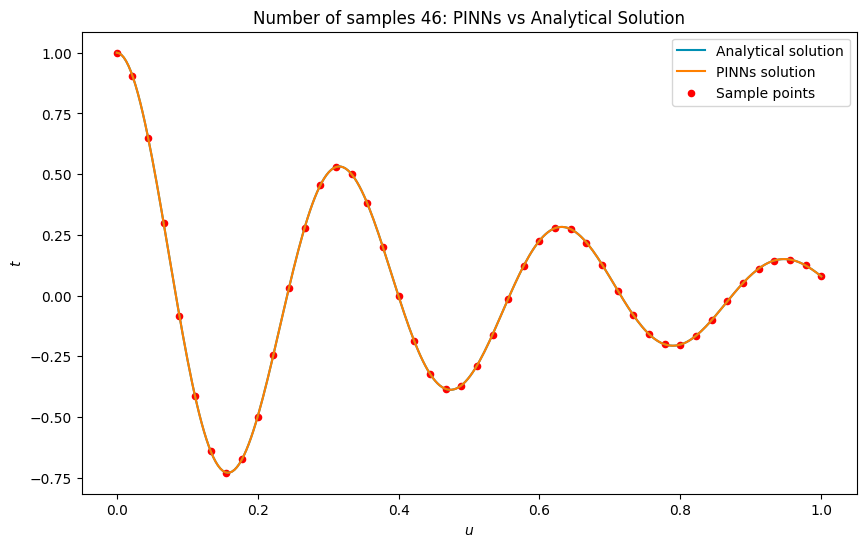

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(t_test, u_test, color=light_cyan,label="Analytical solution")
plt.plot(t_test, u_test_pred_numpy, color=light_orange,label="PINNs solution")
plt.title(f"Number of samples {46}: PINNs vs Analytical Solution")
plt.xlabel("$u$")
plt.ylabel("$t$")
plt.scatter(t_pde_numpy, u_pde_numpy_exact, color="red", s=20, label="Sample points")
plt.legend()
plt.show()